In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:

# Define functions
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = int(parts[4])
            edges.append((res1, res2, weight))
    return edges

def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("ATOM"):
                res_number = int(line[22:26].strip())
                res_type = line[17:20].strip()
                chain = line[21].strip()
                pdb_data[res_number] = (res_type, chain)
    return pdb_data


def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),
        'RBD': set(range(331, 529)).union(range(1459, 1657)).union(range(2587, 2785)),
        'RBM': set(range(437, 509)).union(range(1565, 1637)).union(range(2693, 2765)),
        'CTD2': set(range(529, 590)).union(range(1657, 1718)).union(range(2785, 2846)),
        'CTD3': set(range(590, 676)).union(range(1691, 698)).union(range(1718, 1804)).union(range(1819, 1826)).union(range(2846, 2932)).union(range(2947, 2954)),
        'FCS': set(range(675, 691)).union(range(1803, 1819)).union(range(2931, 2947)),
        'FP': set(range(817, 835)).union(range(1945, 1963)).union(range(3073, 3091)),
        'FPPR': set(range(835, 856)).union(range(1963, 1984)).union(range(3091, 3112)),
        'HR1': set(range(910, 986)).union(range(2038, 2114)).union(range(3166, 3242)),
        'CH': set(range(985, 1035)).union(range(2113, 2163)).union(range(3241, 3291)),
        'CD': set(range(1035, 1069)).union(range(2163, 2197)).union(range(3291, 3325)),
        'Glycans': range(3389, 3880),
        'Mucins' :set(range(3880, 3999)).union(range(4419, 4538)).union(range(4538, 4657)).union( range(3999, 4139)).union(range(4279, 4419)).union(range(4139, 4279))
    #    'Chain M': range(3880, 3999),
    #    'Chain N': range(4419, 4538),
    #    'Chain O': range(4538, 4657),
    #    'Chain P': range(3999, 4139),
    #    'Chain Q': range(4279, 4419),
    #    'Chain R': range(4139, 4279)
    }
    
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

def generate_output_file(edges, pdb_data, output_file):
    with open(output_file, 'w') as file:
        for res1, res2, weight in edges:
            res1_info = pdb_data.get(res1, ("Unknown", "Unknown"))
            res2_info = pdb_data.get(res2, ("Unknown", "Unknown"))
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            file.write(f"Edge {res1}-{res2}-{weight}; {res1_info[0]}-{domain1}-{res1_info[1]} -> {res2_info[0]}-{domain2}-{res2_info[1]}\n")

def create_domain_residue_list(edges, pdb_data):
    domain_residues = defaultdict(set)
    for res1, res2, _ in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        if domain1:
            domain_residues[domain1].add(res1)
        if domain2:
            domain_residues[domain2].add(res2)
    return domain_residues

def plot_domain_weights(edge_files, pdb_data):
    domain_weights_list = []
    
    for file in edge_files:
        edges = read_edge_usage(file)
        domain_weights = defaultdict(int)
        for res1, res2, weight in edges:
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            if domain1:
                domain_weights[domain1] += weight
            if domain2:
                domain_weights[domain2] += weight
        domain_weights_list.append(domain_weights)
    
    all_domains = set()
    for weights in domain_weights_list:
        all_domains.update(weights.keys())
    

    normalized_weights = {}
    for domain in all_domains:
        domain_values = [weights.get(domain, 0) for weights in domain_weights_list]
        total_weight = sum(domain_values)
        if total_weight > 0:
            normalized_weights[domain] = (sum(domain_values) / len(domain_values), pd.Series(domain_values).std())
    
    # Plotting
    domains = list(normalized_weights.keys())
    means = [normalized_weights[d][0] for d in domains]
    stds = [normalized_weights[d][1] for d in domains]
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 10))
    plt.bar(domains, means, yerr=stds, capsize=5, color='skyblue')
    plt.xlabel('Domains')
    plt.ylabel('Normalized Weights')
    plt.title('Normalized Addition of Weights Corresponding to Each Domain (with Std Dev)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


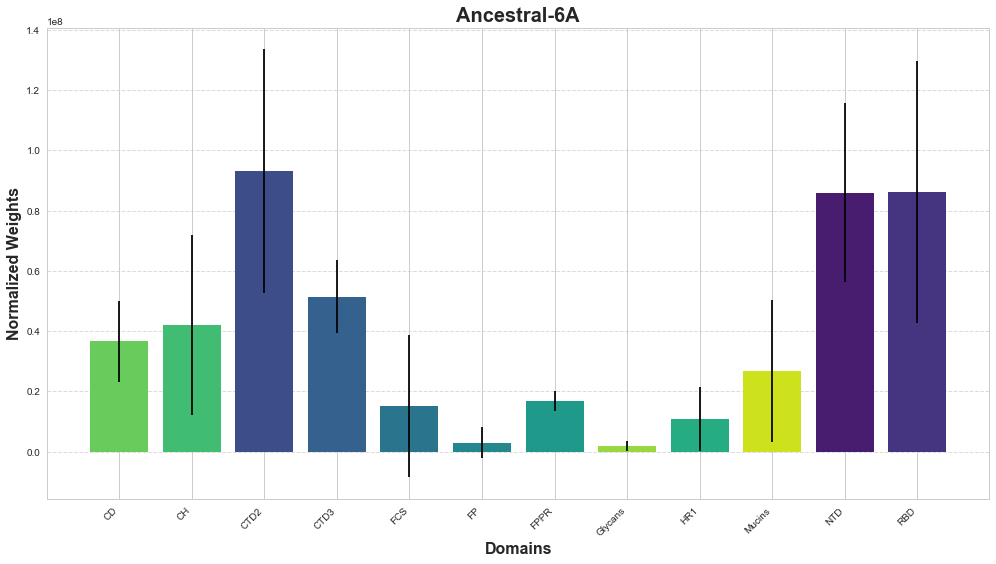

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def plot_domain_weights(edge_files, pdb_data, order=None):
    domain_weights_list = []
    
    for file in edge_files:
        edges = read_edge_usage(file)
        domain_weights = defaultdict(int)
        for res1, res2, weight in edges:
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            if domain1:
                domain_weights[domain1] += weight
            if domain2:
                domain_weights[domain2] += weight
        domain_weights_list.append(domain_weights)
    
    all_domains = set()
    for weights in domain_weights_list:
        all_domains.update(weights.keys())
    
    normalized_weights = {}
    for domain in all_domains:
        domain_values = [weights.get(domain, 0) for weights in domain_weights_list]
        total_weight = sum(domain_values)
        if total_weight > 0:
            normalized_weights[domain] = (sum(domain_values) / len(domain_values), pd.Series(domain_values).std())
    
    # Sort the domains according to the specified order or by total normalized weight
    if order:
        sorted_domains = order
    else:
        sorted_domains = sorted(normalized_weights.keys(), key=lambda x: normalized_weights[x][0], reverse=True)
    
    means = [normalized_weights[d][0] for d in sorted_domains]
    stds = [normalized_weights[d][1] for d in sorted_domains]
    
    # Set style
    sns.set(style="whitegrid")
    
    # Plotting
    plt.figure(figsize=(14, 8))
    bars = plt.bar(sorted_domains, means, yerr=stds, capsize=5, color=sns.color_palette('viridis', len(sorted_domains)))
    
    # Adding data labels
    #for bar, mean, std in zip(bars, means, stds):
    #    yval = bar.get_height()
    #    plt.text(bar.get_x() + bar.get_width()/2, yval + std + 0.01, f'{mean:.2f}\n±{std:.2f}', 
    #             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    
    plt.xlabel('Domains', fontsize=16, fontweight='bold')
    plt.ylabel('Normalized Weights', fontsize=16, fontweight='bold')
    plt.title('Ancestral-6A', fontsize=20, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
pdb_file_path = "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/combined.pdb"
edge_files = ["/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/edge_usage_500.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep2/dist6/edge_usage_500.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep3/dist6/edge_usage_500.txt"]  # List all edge files here
# Define your desired order or use None for sorting by normalized weight
#desired_order = None  # Or set this to ['NTD', 'RBD', 'RBM', ...] as needed
desired_order = ['NTD', 'RBD', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 'HR1', 'CH', 'CD', 'Glycans', 'Mucins']

# Read PDB data
pdb_data = read_pdb(pdb_file_path)

plot_domain_weights(edge_files, pdb_data, order=desired_order)
